
# Customer segmentation and optimal (ctaCopy x ctaPlacement) testing

**Author:** Gregory Yampolsky  
**Date:** 2025-08-28

The goal of this notebook is to determine the optimal combination to use for `ctaCopy` and `ctaPlacement` to maximize, our key metric, `revenue`.  To do this we will segment the data using k-means clustering and find the optimal cta combination for each cluster.  We will choose our clusters and policies based off of a training set and compare it against the baseline on the test set.

I apologize if my notebook is too long, but I wanted to make sure that my experiments and answers were thorough.  If you have any questions please reach out to me at gregyampolsky@gmail.com



## Import libraries

In [ ]:
# imports

# Standard library
import ast
import os
import pickle
import re
import sys
import textwrap
import time
from time import time

# Third-party
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr, ttest_ind

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# scikit-learn
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    log_loss,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


# Reproducibility & display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)



## Read csv and sanity checks

I chose to make this notebook in google colab to take advantage of the more powerful computes they offer on the cloud as well as to more seamlessly integrate my notebook with my google drive.

If you would like to run this on a local instead please replace how you read the csv.


In [ ]:

#read the csv
from google.colab import drive
drive.mount('/content/drive')

GDRIVE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/"#change folder path specific to your organization
df = pd.read_csv(GDRIVE_FOLDER+'train.csv') #comment out if on local/ change folder path to match your structure.
#df = pd.read_csv(<file location on local>)    <-use this instead of the two lines above if youre running on local instead of google colab.
print(df.shape)
df.head()

Mounted at /content/drive
(100000, 18)


,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue
0,9/1/24,user_97048,Google,Safari,Mobile,152000.0,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",75,0,0,0,NaN,NaN
1,9/1/24,user_14393,Social,Safari,Mobile,140000.0,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,25,0,0,0,NaN,NaN
2,9/1/24,user_30959,Direct,Safari,Mobile,128000.0,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,75,0,0,0,NaN,NaN
3,9/1/24,user_88588,Google,Chrome,Mobile,205000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,75,1,1,0,NaN,NaN
4,9/1/24,user_65965,Google,Safari,Mobile,NaN,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,NaN,NaN


If `revenue` is our target column then we will have to drop `clickedCta`,`submittedForm`, `scheduledAppointment` when training our model as those columns contain information about the target column.



**Checking for any null values**

In [ ]:

# Basic schema / nulls / target prevalence
df.info()
print("\nNulls per column:\n", df.isna().sum().sort_values(ascending=False))

target_col = "revenue"  # as specified in the case


ctr = df[target_col].mean()
print(f"\nBaseline (mean of {target_col}): {ctr:.4f}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   100000 non-null  object 
 1   userId                 100000 non-null  object 
 2   sessionReferrer        100000 non-null  object 
 3   browser                100000 non-null  object 
 4   deviceType             100000 non-null  object 
 5   estimatedAnnualIncome  79986 non-null   float64
 6   estimatedPropertyType  100000 non-null  object 
 7   visitCount             100000 non-null  int64  
 8   pageURL                100000 non-null  object 
 9   ctaCopy                100000 non-null  object 
 10  ctaPlacement           100000 non-null  object 
 11  editorialSnippet       100000 non-null  object 
 12  scrollDepth            100000 non-null  int64  
 13  clickedCTA             100000 non-null  int64  
 14  submittedForm          100000 non-nul

**checking for duplicates**

In [ ]:
# Duplicate checks: rows & userId

# 1) Exact duplicate rows (all columns identical)
dup_row_mask = df.duplicated(keep=False)
print(f"Duplicate rows (including first occurrences): {int(dup_row_mask.sum())}")
if dup_row_mask.any():
    print("Showing up to 10 duplicate rows:")
    display(df[dup_row_mask].head(10))

# 2) Duplicate userId occurrences
user_id_col = 'userId'
vc = df[user_id_col].value_counts(dropna=False)
dupe_ids = vc[vc > 1]
print(f"\nUnique IDs appearing more than once: {int(dupe_ids.shape[0])}")
if not dupe_ids.empty:
    print(f"Max repeats for a single ID: {int(dupe_ids.max())}")
    print("\nTop repeated IDs (count):")
    display(dupe_ids.head(20).to_frame("count"))

    print("\nSample rows for repeated IDs:")
    sample = df[df[user_id_col].isin(dupe_ids.index)].sort_values(user_id_col).head(20)
    display(sample)

# Quick summary stats
extra_rows_beyond_first = int(df.duplicated(subset=[user_id_col]).sum())
print(f"\nRows beyond first occurrences for repeated IDs: {extra_rows_beyond_first}")


Duplicate rows (including first occurrences): 0

Unique IDs appearing more than once: 0

Rows beyond first occurrences for repeated IDs: 0


Fortunately there were no duplicates but there were many missing entries for income.  

### 2. Exploratory Data Analysis

**Cat columns EDA**
Number of unique features in each categorical column

In [ ]:
# Unique values for key categorical columns
cat_cols = ["sessionReferrer", "browser", "deviceType", "estimatedPropertyType"]

# Summary: number of unique values per column
summary = {
    col: (df[col].nunique(dropna=True) if col in df.columns else None)
    for col in cat_cols
}
print("Number of unique categories of each cat column:")
display(pd.DataFrame.from_dict(summary, orient="index", columns=["n_unique"]))


Number of unique categories of each cat column:


,n_unique
sessionReferrer,4
browser,4
deviceType,2
estimatedPropertyType,4


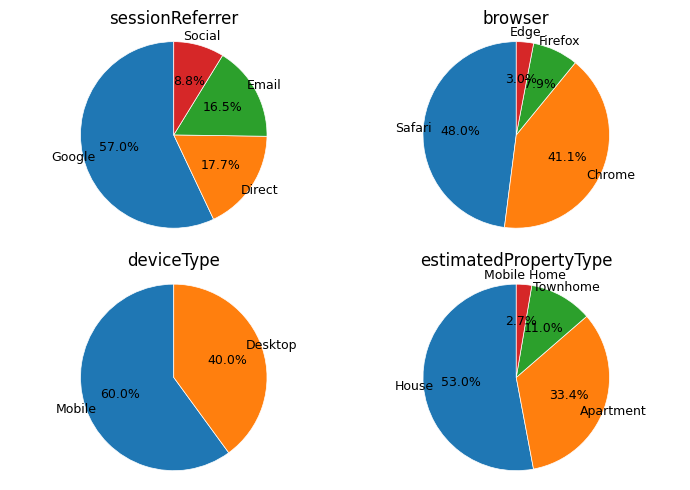

In [ ]:
# creating pie charts to show distributions of categories


top_n = 8  # max distinct labels per pie (rest grouped into "Other")
# function to group anything past top_n as other
def topn_with_other(series, top_n=8):
    feature_categories = series.fillna("(missing)").astype(str).value_counts()
    if feature_categories.shape[0] > top_n:
        top = feature_categories.head(top_n - 1)  # reserve a slot for "Other"
        other = feature_categories.iloc[top_n - 1:].sum()
        feature_categories = top.copy()
        feature_categories.loc["Other"] = other
    return feature_categories

# for 4 features make 2 rows of 2 pie charts
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    feature_categories = topn_with_other(df[col], top_n=top_n)
    ax = axes[i]
    ax.pie(
        feature_categories.values,
        labels=feature_categories.index,
        autopct=lambda p: f"{p:.1f}%",
        startangle=90,
        wedgeprops=dict(linewidth=0.5, edgecolor="white"),
        textprops=dict(ha="center", va="center", fontsize=9)
    )
    ax.set_title(col)
    ax.axis("equal")  # circles

plt.tight_layout()
plt.show()

**Time series EDA**

/tmp/ipython-input-4030916998.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d['date'] = pd.to_datetime(d['date'], errors="coerce")


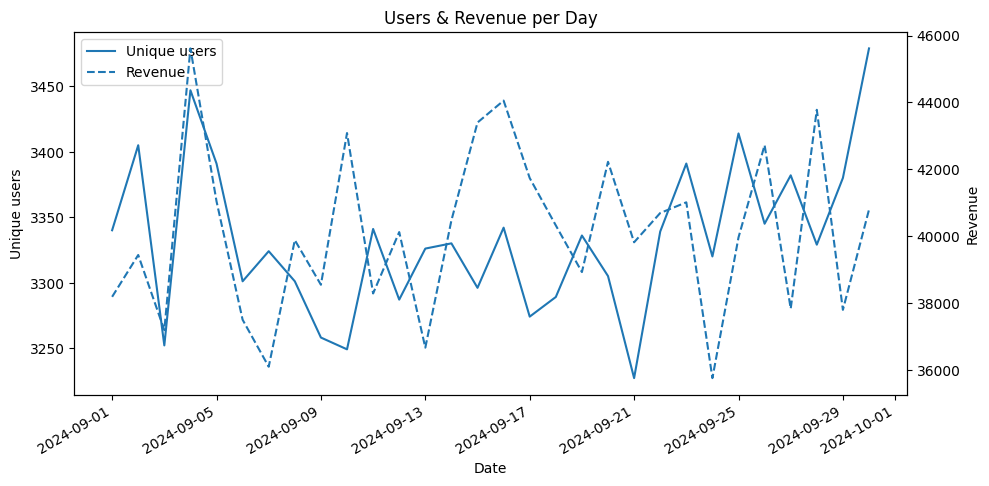

In [ ]:
# Time series: total unique users and total revenue per date (overlay)

# --- Prep & aggregate daily ---
d = df.copy()
d['date'] = pd.to_datetime(d['date'], errors="coerce")
d = d.dropna(subset=['date'])
d["date"] = d['date'].dt.normalize()

# unique users per day
ts_users = d.groupby("date")['userId'].nunique().rename("unique_users")

# total revenue per day (0 if all values that day are null)
d['revenue'] = pd.to_numeric(d['revenue'], errors="coerce")  # don't fill here
ts_rev = (
    d.groupby("date")['revenue']
      .sum(min_count=1)   # NaN if all entries are NaN
      .fillna(0)          # turn those all-NaN days into 0
      .rename("revenue")
)

# align indices
idx = ts_users.index.union(ts_rev.index)
ts_users = ts_users.reindex(idx, fill_value=0)
ts_rev = ts_rev.reindex(idx, fill_value=0)

# --- Plot overlay with secondary y-axis ---
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(idx, ts_users.values, label="Unique users")
ax1.set_xlabel("Date")
ax1.set_ylabel("Unique users")

ax2 = ax1.twinx()
ax2.plot(idx, ts_rev.values, linestyle="--", label="Revenue")
ax2.set_ylabel("Revenue")

# Combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    lns, lbs = ax.get_legend_handles_labels()
    lines += lns; labels += lbs
ax1.legend(lines, labels, loc="upper left")

plt.title("Users & Revenue per Day")
plt.tight_layout()

plt.gcf().autofmt_xdate()

Since the dates only span one month I think it would be wise to convert them to days of the week. From my experience things like CTR are often correlated to DOW as people might spend more on a friday when they get their paychecks.


**Longer text EDA**

In [ ]:
#unique pageurl

base = "https://www.financialservices.com/mortgages/"

s = (
    df["pageURL"]
    .dropna()
    .astype(str)
    .str.replace("^" + re.escape(base), "", regex=True)  # remove only if at the start
)
display(
    s.value_counts()
     .rename("count")
     .to_frame()
     .reset_index()
     .rename(columns={"index": "path_after_prefix_removed"})
)

#unique editorial snippets
display(
    df['editorialSnippet'].value_counts()
     .rename("count")
     .to_frame()
     .reset_index()
     .rename(columns={"index": "editorialSnippet"})
)

,pageURL,count
0,how-to-get-the-best-mortgage-rate,10166
1,mortgage-calculator,10145
2,best-mortgage-lenders,10084
3,30-year-mortgage-rates,10007
4,types-of-mortgages,9988
5,what-is-mortgage,9970
6,refinance-rates,9961
7,reviews,9905
8,apply,9894
9,first-time-homebuyer-guide,9880


,editorialSnippet,count
0,From improving your credit score to timing you...,3446
1,Take control of your mortgage journey with our...,3435
2,Understand how market fluctuations impact long...,3424
3,Discover the top mortgage lenders of the year....,3415
4,Equip yourself with knowledge. Understand the ...,3385
5,Explore the different types of mortgages avail...,3382
6,Our mortgage calculator is a powerful tool for...,3381
7,Our tools help you assess whether refinancing ...,3367
8,Discover what sets top mortgage lenders apart....,3366
9,"Compare rates, customer service, and loan opti...",3355


In [ ]:
# checking the number of unique words in the editorial snippets column as to help decide if we should use tf-idf for encoding

# tokenize: keep letters/numbers/apostrophes, lowercase
pattern = r"[a-z0-9']+"
s = df['editorialSnippet'].dropna().astype(str).str.lower()

# explode to one token per row
words = s.str.findall(pattern).explode().dropna()

# unique, sorted
unique_words = np.sort(words.unique())
print(f"Unique words: {len(unique_words)}")

# peek
print('first 50:\n', unique_words[:50])  # first 50 alphabetically

# Show as a dataframe
display(pd.DataFrame({"word": unique_words}))

Unique words: 264
first 50:
 ['30' 'a' 'about' 'accurate' 'actionable' 'addressing' 'adjustable'
 'advantage' 'affect' 'aligns' 'an' 'analyses' 'and' 'apart' 'application'
 'are' 'as' 'assess' 'available' 'backed' 'basics' 'benefits' 'best'
 'borrower' 'borrowing' 'break' 'budget' 'budgeting' 'build' 'buyers'
 'buying' 'by' 'calculate' 'calculator' 'can' 'changes' 'choice' 'choose'
 'circumstances' 'clarifying' 'clarity' 'clear' 'closing' 'compare'
 'competitiveness' 'compiled' 'complexities' 'comprehensive' 'concepts'
 'confidence']


,word
0,30
1,a
2,about
3,accurate
4,actionable
...,...
259,work
260,year
261,you
262,your


**Numerical Features EDA**


estimatedAnnualIncome — n=79986, mean=1.31e+05, std=6.24e+04, min=5e+04, 25%=9e+04, 50%=1.16e+05, 75%=1.45e+05, max=4e+05


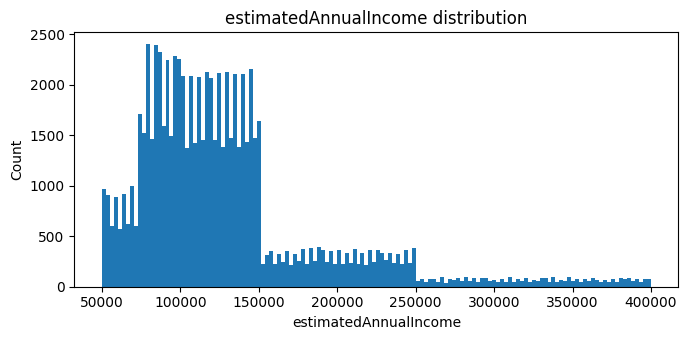


visitCount — n=100000, mean=2.23, std=2.07, min=1, 25%=1, 50%=1, 75%=3, max=10


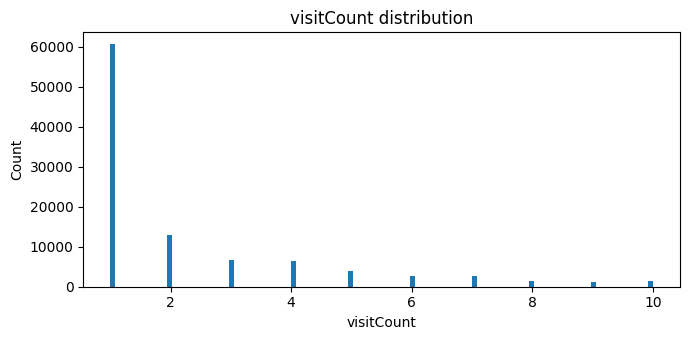


scrollDepth — n=100000, mean=62.3, std=30.1, min=0, 25%=50, 50%=75, 75%=75, max=100


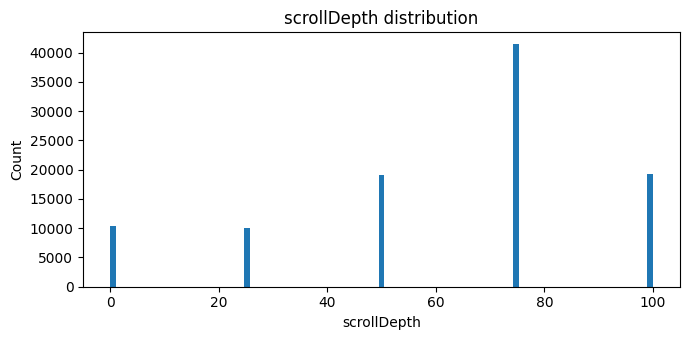

In [ ]:
# Distributions for estimatedAnnualIncome, visitCount, scrollDepth


num_cols = ["estimatedAnnualIncome", "visitCount", "scrollDepth"]

for col in num_cols:
    if col not in df.columns:
        print(f"{col} not found; skipping.")
        continue

    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric values after coercion; skipping.")
        continue

    # Quick stats
    print(
        f"\n{col} — n={len(s)}, mean={s.mean():.3g}, std={s.std(ddof=1):.3g}, "
        f"min={s.min():.3g}, 25%={s.quantile(0.25):.3g}, "
        f"50%={s.median():.3g}, 75%={s.quantile(0.75):.3g}, max={s.max():.3g}"
    )

    # Histogram (linear x-axis)
    plt.figure(figsize=(7, 3.5))
    plt.hist(s, bins="auto")
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Optional: log-x version for heavily right-skewed, strictly positive data
    if (s > 0).all() and (s.max() / max(s.min(), 1e-12) > 100):
        plt.figure(figsize=(7, 3.5))
        plt.hist(s, bins="auto")
        plt.xscale("log")
        plt.title(f"{col} distribution (log x-axis)")
        plt.xlabel(f"{col} (log scale)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()



## Target Metric by CTA Copy & Placement
We evaluate **CTR (mean of `clickedCTA`)** across `ctaCopy` and `ctaPlacement`.

**Counts of `clickedCTA`**



revenue — n=100000, mean=12, std=51.9, min=0, 25%=0, 50%=0, 75%=0, max=375


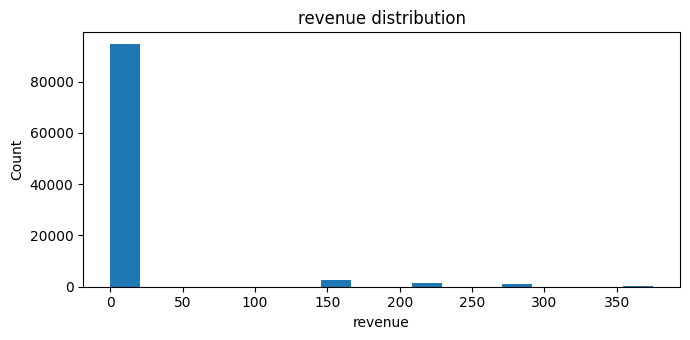

In [ ]:
s = pd.to_numeric(df[target_col], errors="coerce").fillna(0.0)


# Quick stats
print(
    f"\n{target_col} — n={len(s)}, mean={s.mean():.3g}, std={s.std(ddof=1):.3g}, "
    f"min={s.min():.3g}, 25%={s.quantile(0.25):.3g}, "
    f"50%={s.median():.3g}, 75%={s.quantile(0.75):.3g}, max={s.max():.3g}"
)

# Histogram (linear x-axis)
plt.figure(figsize=(7, 3.5))
plt.hist(s, bins="auto")
plt.title(f"{target_col} distribution")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

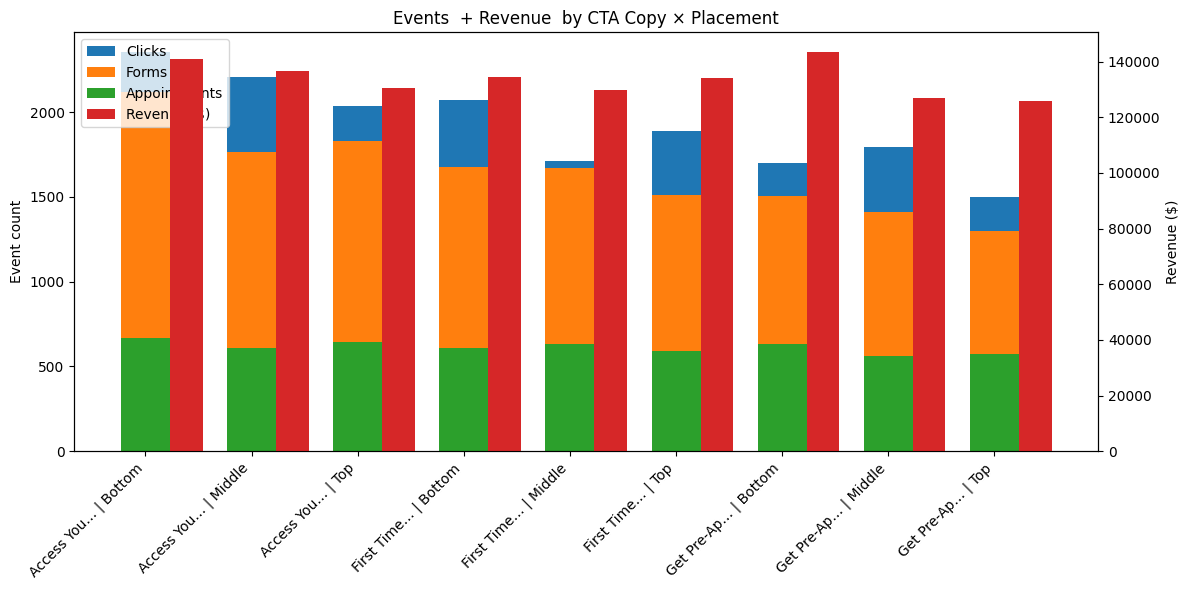

In [ ]:
# Events overlaid (smaller in front) + tangent revenue on 2nd y-axis, with small gaps between groups

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# aggregate (0/1 -> sums)
agg = (
    df.groupby(["ctaCopy", "ctaPlacement"])[["clickedCTA", "submittedForm", "scheduledAppointment", "revenue"]]
      .sum()
      .reset_index()
)

# compact x-labels
copy_short = np.where(agg["ctaCopy"].str.len() > 11, agg["ctaCopy"].str[:10] + "…", agg["ctaCopy"])
labels = copy_short + " | " + agg["ctaPlacement"]

# order by total events
agg["Total"] = agg[["clickedCTA","submittedForm","scheduledAppointment"]].sum(1)
agg = agg.sort_values("Total", ascending=False).reset_index(drop=True)

# positions (smaller gap than before)
n = len(agg)
wE, wR, gap = 0.6, 0.4, 0.3
x = np.arange(n) * (wE + wR + gap)
x_rev = x + (wE/2 + wR/2)  # revenue tangent to event bars

fig, ax = plt.subplots(figsize=(12, 6))

# overlay event bars at x (draw big -> small so small is in front)
events = [("clickedCTA","Clicks","C0"), ("submittedForm","Forms","C1"), ("scheduledAppointment","Appointments","C2")]
for i in range(n):
    vals = [(name, agg.at[i, col], colr) for col, name, colr in events]
    for name, val, colr in sorted(vals, key=lambda t: t[1], reverse=True):
        ax.bar(x[i], val, width=wE, color=colr)

ax.set_ylabel("Event count")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Events  + Revenue  by CTA Copy × Placement")

# revenue bars on 2nd axis (solid)
ax2 = ax.twinx()
ax2.bar(x_rev, agg["revenue"].astype(float).values, width=wR, color="C3")
ax2.set_ylabel("Revenue ($)")

# legend
ax.legend(
    handles=[Patch(facecolor=c, label=n) for _, n, c in events] + [Patch(facecolor="C3", label="Revenue ($)")],
    loc="upper left"
)

plt.tight_layout()
plt.show()


It's worth noting that higher clicks does not necessarily translate to more forms filled, more forms filled does not translate to more appointments, and more appointments does not always lead to more revenue.  If our goal is to maximize revenue we should focus on average revenue/impression as our kpi.

**exploring best `ctaCopy` and `ctaPlacement` to choose overall**

In [ ]:

# distributions of ctr for each combination of ctacopy and ctaplacement
group_cols = ["ctaCopy", "ctaPlacement"]
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce").fillna(0.0)

summary = (df.groupby(group_cols)["revenue"]
             .agg(["mean","std","count","sum"])
             .reset_index()
             .sort_values("mean", ascending=False)
             .reset_index(drop=True))
display(summary)

best_row = summary.iloc[0]
best_placement, best_copy = best_row["ctaPlacement"], best_row["ctaCopy"]

mask_best = (df["ctaPlacement"]==best_placement) & (df["ctaCopy"]==best_copy)
best_revs = df.loc[mask_best, "revenue"].to_numpy()
rest_revs = df.loc[~mask_best, "revenue"].to_numpy()

# Mann–Whitney U (one-sided best>rest)
u_stat, p_mw = mannwhitneyu(best_revs, rest_revs, alternative="greater")

# Welch t-test (one-sided best>rest) with fallback for older SciPy
t_stat, p_t = ttest_ind(best_revs, rest_revs, equal_var=False, alternative="greater")


print(f"Best combo: placement='{best_placement}', copy='{best_copy}'")
print(f"n_best={best_revs.size}, n_rest={rest_revs.size}")
print(f"Mean rev/imp (best)={best_revs.mean():.6f} | (rest)={rest_revs.mean():.6f}")
print(f"Mann–Whitney U p(one-sided)={p_mw:.6g} -> {'Significant' if p_mw<0.05 else 'Not significant'} at α=0.05")
print(f"Welch t-test p(one-sided)={p_t:.6g}     -> {'Significant' if p_t<0.05 else 'Not significant'} at α=0.05")


,ctaCopy,ctaPlacement,mean,std,count,sum
0,First Time? We've Made it Easy to Find the Bes...,Bottom,12.905229,54.571499,11111,143390.0
1,Get Pre-Approved for a Mortgage in 5 Minutes,Top,12.680886,52.045969,11112,140910.0
2,First Time? We've Made it Easy to Find the Bes...,Top,12.286923,52.950004,11111,136520.0
3,Access Your Personalized Mortgage Rates Now,Top,12.120871,52.894607,11111,134675.0
4,First Time? We've Made it Easy to Find the Bes...,Middle,12.071371,52.725281,11111,134125.0
5,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,11.753668,49.253386,11111,130595.0
6,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,11.697417,49.632526,11111,129970.0
7,Access Your Personalized Mortgage Rates Now,Middle,11.424264,51.751619,11111,126935.0
8,Access Your Personalized Mortgage Rates Now,Bottom,11.332463,50.752260,11111,125915.0


Best combo: placement='Bottom', copy='First Time? We've Made it Easy to Find the Best Mortgage Rate'
n_best=11111, n_rest=88889
Mean rev/imp (best)=12.905229 | (rest)=11.920991
Mann–Whitney U p(one-sided)=0.163048 -> Not significant at α=0.05
Welch t-test p(one-sided)=0.0356794     -> Significant at α=0.05


In terms of which copy and placement combination performed best overall, its "First Time? We..." with bottom placement as this combination returned the highest revenue. It was significant for the one-sided t-test but not the Mann-Whitney test .

T-test and Mann-Whitney tests measure two different things. t-test measure a difference in the means of two distributions and Mann-Whitney measures if the rankings of items are different. Ultimately if we are trying to measure mean revenue/impression than the t test is what we care most about. This indicates one combination is significantly better and should be chosen. The reason t-test is significant but not Mann-Whitney is likely due to a very heavy right tail as most users do not end up purchasing a home. Since all the 0's are equally ranked, it won't make the distributions seem different.

Given these results, if we had to recommend one combination to use for all users, we would recommend our champion as `"First Time? We've m..."` with `bottom` placement as it was statistically significant at improving revenue.

In [ ]:
# Champion vs. rest — incremental value (revenue per impression)


d["revenue"] = pd.to_numeric(d["revenue"], errors="coerce").fillna(0.0)
for c in ["ctaCopy", "ctaPlacement"]:
    d[c] = d[c].astype(str).fillna("(missing)")

group_cols = ["ctaCopy", "ctaPlacement"]
g = (
    d.groupby(group_cols)["revenue"]
     .agg(rev_mean="mean", rev_sum="sum", n="size")
     .reset_index()
)

min_n = 50  # ignore tiny cells
eligible = g[g["n"] >= min_n].copy()
assert not eligible.empty, "No eligible CTA combos with sufficient volume."

# champion = highest revenue per impression among eligible combos
champ = eligible.loc[eligible["rev_mean"].idxmax()]
champ_key = (champ["ctaCopy"], champ["ctaPlacement"])

# rest = impression-weighted average of all other eligible combos
rest = eligible[(eligible["ctaCopy"] != champ_key[0]) | (eligible["ctaPlacement"] != champ_key[1])]
rest_rev_mean = (rest["rev_sum"].sum() / rest["n"].sum()) if rest["n"].sum() > 0 else np.nan

lift_per_impr = champ["rev_mean"] - rest_rev_mean
rpm_lift = 1000 * lift_per_impr  # lift per 1,000 impressions

print(f"Champion: copy='{champ_key[0]}', placement='{champ_key[1]}' (n={int(champ['n'])})")
print(f"Champion revenue/imp: {champ['rev_mean']:.6f}")
print(f"Rest (weighted) revenue/imp: {rest_rev_mean:.6f}")
print(f"Incremental per impression: {lift_per_impr:.6f}")
print(f"Incremental per 1,000 impressions (RPM lift): ${rpm_lift:,.2f}")

# Optional: estimate total incremental revenue for a traffic plan
future_impressions = 100_000  # ← set this to your expected volume
print(f"Estimated incremental revenue for {future_impressions:,} impressions: ${future_impressions * lift_per_impr:,.2f}")


Champion: copy='First Time? We've Made it Easy to Find the Best Mortgage Rate', placement='Bottom' (n=11111)
Champion revenue/imp: 12.905229
Rest (weighted) revenue/imp: 11.920991
Incremental per impression: 0.984238
Incremental per 1,000 impressions (RPM lift): $984.24
Estimated incremental revenue for 100,000 impressions: $98,423.77


In [ ]:

# --- pick the key metric (prefer revenue per impression; else CTR) ---
if "revenue" in d.columns:
    d["metric"] = pd.to_numeric(d["revenue"], errors="coerce").fillna(0.0)
    metric_label = "Revenue per impression"
else:
    target_col = next((c for c in d.columns if c.lower() == "clickedcta"), None)
    assert target_col is not None, "clickedCTA not found and no revenue column."
    d["metric"] = pd.to_numeric(d[target_col], errors="coerce").fillna(0).astype(float)
    metric_label = "CTR"

# helpful extra segment: day-of-week from `date`, if available
if "date" in d.columns:
    d["dayOfWeek"] = pd.to_datetime(d["date"], errors="coerce").dt.day_name().fillna("(unknown)")

# define segment columns (keep only those that exist)
cat_cols = [c for c in ["deviceType","browser","sessionReferrer","estimatedPropertyType","dayOfWeek"] if c in d.columns]
num_cols = [c for c in ["estimatedAnnualIncome","visitCount","scrollDepth"] if c in d.columns]

# fill missing categories with a label
for c in cat_cols:
    d[c] = d[c].astype(str).fillna("(missing)")

baseline = d["metric"].mean()
min_n = 50  # ignore tiny groups

def summarize_cat(col, top_k=5):
    s = (
        d.groupby(col, dropna=False)["metric"]
         .agg(mean="mean", n="size", total="sum", std="std")
         .reset_index()
    )
    s["std"] = s["std"].fillna(0.0)
    s["lift_abs"] = s["mean"] - baseline
    s["lift_rel_%"] = np.where(baseline > 0, 100 * s["lift_abs"] / baseline, np.nan)
    s = s.sort_values("mean", ascending=False)
    eligible = s.query("n >= @min_n").copy()
    print(f"\n=== {col} — best/worst by {metric_label} (n ≥ {min_n}) ===")
    if eligible.empty:
        print("No groups with enough samples.")
        return
    display(eligible.head(top_k))

# --- categorical groups: show who is higher/lower than baseline ---
print(f"Baseline {metric_label}: {baseline:.6f}")
for c in cat_cols:
    summarize_cat(c, top_k=5)

# --- numeric features: Spearman correlation with the metric ---
if num_cols:
    rows = []
    # Ensure metric is numeric and median-imputed
    m = pd.to_numeric(d["metric"], errors="coerce")
    if m.isna().any():
        m = m.fillna(m.median())

    for c in num_cols:
        x = pd.to_numeric(d[c], errors="coerce")

        # median-impute feature
        x = x.fillna(x.median())

        # Spearman on all rows now that both series are imputed
        rho, p = spearmanr(x, m)
        rows.append({"feature": c, "spearman_rho": rho, "p_value": p, "n": int(len(x))})

    num_corr = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
    print("\n=== Numeric feature correlations with key metric (Spearman, median-imputed) ===")
    display(num_corr)



Baseline Revenue per impression: 12.030350

=== deviceType — best/worst by Revenue per impression (n ≥ 50) ===


,deviceType,mean,n,total,std,lift_abs,lift_rel_%
0,Desktop,14.383601,39966,574855.0,56.433325,2.353251,19.560953
1,Mobile,10.463737,60034,628180.0,48.527634,-1.566613,-13.022171



=== browser — best/worst by Revenue per impression (n ≥ 50) ===


,browser,mean,n,total,std,lift_abs,lift_rel_%
2,Firefox,13.995586,7930,110985.0,55.430275,1.965236,16.335654
1,Edge,13.235097,2986,39520.0,53.848534,1.204747,10.014232
0,Chrome,12.131215,41108,498690.0,52.138071,0.100865,0.838424
3,Safari,11.544105,47976,553840.0,50.882983,-0.486245,-4.041816



=== sessionReferrer — best/worst by Revenue per impression (n ≥ 50) ===


,sessionReferrer,mean,n,total,std,lift_abs,lift_rel_%
0,Direct,17.104255,17745,303515.0,61.279943,5.073905,42.175870
1,Email,15.562170,16463,256200.0,58.579716,3.531820,29.357581
2,Google,10.548463,57023,601505.0,48.737997,-1.481887,-12.317905
3,Social,4.768503,8769,41815.0,32.386417,-7.261847,-60.362727



=== estimatedPropertyType — best/worst by Revenue per impression (n ≥ 50) ===


,estimatedPropertyType,mean,n,total,std,lift_abs,lift_rel_%
0,Apartment,13.546045,33402,452465.0,52.989959,1.515695,12.598928
3,Townhome,11.505381,10964,126145.0,50.226686,-0.524969,-4.363703
1,House,11.289506,52966,597960.0,51.916308,-0.740844,-6.158121
2,Mobile Home,9.919415,2668,26465.0,41.969277,-2.110935,-17.546744



=== dayOfWeek — best/worst by Revenue per impression (n ≥ 50) ===


,dayOfWeek,mean,n,total,std,lift_abs,lift_rel_%
4,Thursday,12.188412,13359,162825.0,52.023400,0.158062,1.313863
6,Wednesday,12.170706,13491,164195.0,52.407783,0.140356,1.166686
2,Saturday,12.125284,13210,160175.0,51.837285,0.094934,0.789120
1,Monday,12.080296,16875,203855.0,52.192192,0.049946,0.415169
5,Tuesday,12.048874,13095,157780.0,52.411037,0.018524,0.153974



=== Numeric feature correlations with key metric (Spearman, median-imputed) ===


,feature,spearman_rho,p_value,n
2,scrollDepth,0.106440,9.067093e-250,100000
1,visitCount,0.032891,2.384805e-25,100000
0,estimatedAnnualIncome,-0.010850,6.013903e-04,100000


After running a t test to compare probability of click for each copy and placement combination, we can see that the best combo("Get Pre-Approv..." and Top) was measureably better over othe combinations when it came to improving CTR.

According to these the best placement is top and the best copy is "Get Pre-App..." when it comes to maximizing CTR of the CTA banner.


## Choosing policy with Segmentation

### Leakage Audit
Columns that are **post-click** or downstream of the target (e.g., `submittedForm`, `scheduledAppointment`, `mortgageVariation`, `revenue`) are **excluded** from training features to avoid leaking future information.


In [ ]:

# Identify columns
all_cols = df.columns.tolist()
post_click_cols = [c for c in all_cols if c.lower() in [
    "clickedcta","submittedform","scheduledappointment","mortgagevariation","revenue"
]]
target_col='revenue'
# Target & identifier
id_col = "userId"

# Candidate features (exclude target, post-click, and id)
feature_cols = [c for c in all_cols if c not in set([target_col]) | set(post_click_cols) | set([id_col] if id_col else [])]

print("Excluded (post-click) columns:", post_click_cols)
print("Using features:", feature_cols)


Excluded (post-click) columns: ['clickedCTA', 'submittedForm', 'scheduledAppointment', 'mortgageVariation', 'revenue']
Using features: ['date', 'sessionReferrer', 'browser', 'deviceType', 'estimatedAnnualIncome', 'estimatedPropertyType', 'visitCount', 'pageURL', 'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrollDepth']



## 4. Feature Engineering Plan

- **Numeric:** `estimatedAnnualIncome`, `visitCount`, `scrollDepth` (scaled)
- **Categorical:** `sessionReferrer`, `browser`, `deviceType`, `estimatedPropertyType`, `ctaCopy`, `ctaPlacement` (one-hot)
- **Date:** `date` (converted to DOW and then one-hot).  
- **Text:** `editorialSnippet`,`pageURL` (target).  

I also experimented using `randomOverSampler` from `imblearn` to deal with the imbalanced nature of the dataset.

All steps are built into a single `sklearn`/`imblearn` **Pipeline** with a `ColumnTransformer`.


In [ ]:
# sample only 5000 rows for experimenting only to speed things up
#comment out when ready
#df = df.sample(n=10000, random_state=RANDOM_STATE, replace=False).reset_index(drop=True)

In [ ]:



numeric_features = ["estimatedAnnualIncome", "visitCount", "scrollDepth"]
categorical_features = ["sessionReferrer", "browser", "deviceType", "estimatedPropertyType", "ctaCopy", "ctaPlacement",'pageURL','editorialSnippet']
date_features = ['date']

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("datetime:", date_features)


Numeric: ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']
Categorical: ['sessionReferrer', 'browser', 'deviceType', 'estimatedPropertyType', 'ctaCopy', 'ctaPlacement', 'pageURL', 'editorialSnippet']
datetime: ['date']


In [ ]:
# Preprocessors
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# for date convert to day of the week and one hot encode
def _date_to_dow_2d(X):
    s = pd.Series(np.asarray(X).ravel(), dtype="string").str.strip()
    s = s.replace("", pd.NA)  # treat empty as missing
    dt = pd.to_datetime(s, format="%m/%d/%y", errors="coerce")
    dow = dt.dt.day_name().fillna("(unknown)")
    return dow.to_numpy().reshape(-1, 1)

date_feature = "date" if "date" in df.columns else None
date_transformer = Pipeline(steps=[
    ("to_dow", FunctionTransformer(_date_to_dow_2d, validate=False)),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])




#building preprocessor
pre_clust = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("dow", date_transformer, date_features),
    ],
    remainder="drop",
    sparse_threshold=0.3
)



### k-means clustering with policy evaluation


k* = 7 | train avg $/imp = 16.030965 | test avg $/imp = 16.051765


,cluster,ctaCopy,ctaPlacement,rev_mean,n,n_cluster
0,0,Access Your Personalized Mortgage Rates Now,Middle,19.854413,1099,9951
1,1,First Time? We've Made it Easy to Find the Bes...,Middle,19.510386,1348,12096
2,2,Access Your Personalized Mortgage Rates Now,Top,14.054855,1349,12190
3,3,Access Your Personalized Mortgage Rates Now,Middle,18.846154,637,5857
4,4,Access Your Personalized Mortgage Rates Now,Top,6.040396,1312,11937
5,5,First Time? We've Made it Easy to Find the Bes...,Bottom,14.320000,875,8229
6,6,First Time? We've Made it Easy to Find the Bes...,Bottom,22.273567,1082,9740


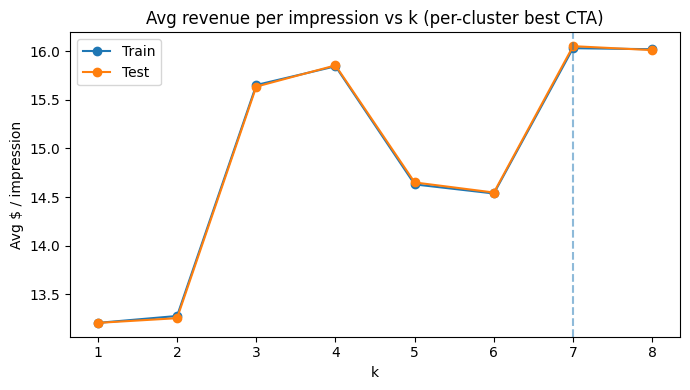

In [ ]:
# Train/Test split, fit clustering on TRAIN only, choose k by TRAIN revenue,
# and plot TRAIN vs TEST policy value (avg $/imp) on one chart.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.base import clone

# 1) split (preserve CTA mix)
arm = df["ctaCopy"].astype(str) + "|" + df["ctaPlacement"].astype(str)
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42, stratify=arm)

# 2) preprocessing (fit on TRAIN, apply to TEST)
pre_clust_train = clone(pre_clust)
X_train = pre_clust_train.fit_transform(train_df[feature_cols])
X_test  = pre_clust_train.transform(test_df[feature_cols])

# 3) TRAIN revenue + arm fields
t = train_df.copy()
t["revenue"] = pd.to_numeric(t["revenue"], errors="coerce").fillna(0.0)
t["ctaCopy"] = t["ctaCopy"].astype(str)
t["ctaPlacement"] = t["ctaPlacement"].astype(str)

def best_per_cluster(labels, df_train, min_n=20):
    """Pick (ctaCopy, ctaPlacement) with highest mean revenue per cluster (TRAIN)."""
    tmp = df_train.assign(cluster=labels)
    g = (tmp.groupby(["cluster","ctaCopy","ctaPlacement"])["revenue"]
           .agg(rev_mean="mean", n="size").reset_index())
    # prefer cells with volume; fallback if needed
    top = (g[g["n"]>=min_n].sort_values(["cluster","rev_mean"], ascending=[True,False])
             .groupby("cluster").head(1))
    if set(top["cluster"]) != set(g["cluster"]):
        add = (g[~g["cluster"].isin(top["cluster"])]
                 .sort_values(["cluster","rev_mean"], ascending=[True,False])
                 .groupby("cluster").head(1))
        top = pd.concat([top, add], ignore_index=True)
    return top.sort_values("cluster").reset_index(drop=True)

def policy_value(best_tbl, counts):
    """Weighted avg revenue/imp given cluster counts."""
    ncol = counts.columns[-1]
    tbl = best_tbl.merge(counts, on="cluster", how="left").fillna({ncol:0})
    total = tbl[ncol].sum()
    return float((tbl["rev_mean"] * tbl[ncol]).sum() / total) if total else 0.0

# 4) evaluate k = 1..8 on TRAIN; compute TRAIN & TEST policy values
k_vals = list(range(1,9))
train_vals, test_vals = [], []
km_map, best_map = {}, {}

for k in k_vals:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train)
    best_tbl = best_per_cluster(km.labels_, t, min_n=20)

    cnt_tr = pd.Series(km.labels_).value_counts().rename_axis("cluster").reset_index(name="n_tr")
    cnt_te = pd.Series(km.predict(X_test)).value_counts().rename_axis("cluster").reset_index(name="n_te")

    train_vals.append(policy_value(best_tbl, cnt_tr))
    test_vals.append(policy_value(best_tbl, cnt_te))
    km_map[k], best_map[k] = km, best_tbl

# 5) choose k by TRAIN curve; expose artifacts for downstream cells
k_best = k_vals[int(np.argmax(train_vals))]
print(f"k* = {k_best} | train avg $/imp = {train_vals[k_vals.index(k_best)]:.6f} | "
      f"test avg $/imp = {test_vals[k_vals.index(k_best)]:.6f}")

kmeans_train = km_map[k_best]
train_df = train_df.copy()
train_df["cluster"] = kmeans_train.labels_
policy_tbl_train = (best_map[k_best]
    .merge(pd.Series(kmeans_train.labels_).value_counts()
           .rename_axis("cluster").reset_index(name="n_cluster"),
           on="cluster", how="left"))
display(policy_tbl_train[["cluster","ctaCopy","ctaPlacement","rev_mean","n","n_cluster"]])

# 6) overlay plot
plt.figure(figsize=(7,4))
plt.plot(k_vals, train_vals, marker="o", label="Train")
plt.plot(k_vals, test_vals,  marker="o", label="Test")
plt.axvline(k_best, linestyle="--", alpha=0.5)
plt.title("Avg revenue per impression vs k (per-cluster best CTA)")
plt.xlabel("k"); plt.ylabel("Avg $ / impression")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Apply train-learned policy to test: estimate total revenue
import numpy as np, pandas as pd

# Transform test with the TRAIN-FITTED preprocessor, then assign clusters
X_test = pre_clust_train.transform(test_df[feature_cols])
test_labels = kmeans_train.predict(X_test)
u = test_df.copy()
u["cluster"] = test_labels

# Map each test cluster to its chosen (ctaCopy, ctaPlacement) and train rev_mean
rev_map = policy_tbl_train.set_index("cluster")["rev_mean"]

# Count test impressions per cluster
counts_test = u["cluster"].value_counts().rename_axis("cluster").reset_index(name="n_test")

# Merge and compute expected total revenue under the policy
eval_tbl = counts_test.merge(rev_map, on="cluster", how="left").fillna({"rev_mean": 0.0})
total_policy_revenue = float((eval_tbl["rev_mean"] * eval_tbl["n_test"]).sum())
avg_policy_rev_per_imp = total_policy_revenue / len(u)

# (Optional) baseline on test (actual mix)
test_baseline = pd.to_numeric(test_df["revenue"], errors="coerce").fillna(0.0).mean()
total_baseline_revenue = test_baseline * len(u)

print(f"Test impressions: {len(u):,}")
print(f"Estimated TOTAL revenue using train policy: ${total_policy_revenue:,.2f}")
print(f"Estimated AVG $/imp using policy: {avg_policy_rev_per_imp:.6f}")
print(f"(Baseline test avg $/imp under current mix: {test_baseline:.6f}; "
      f"total ≈ ${total_baseline_revenue:,.2f})")


Test impressions: 30,000
Estimated TOTAL revenue using train policy: $481,552.94
Estimated AVG $/imp using policy: 16.051765
(Baseline test avg $/imp under current mix: 11.785000; total ≈ $353,550.00)


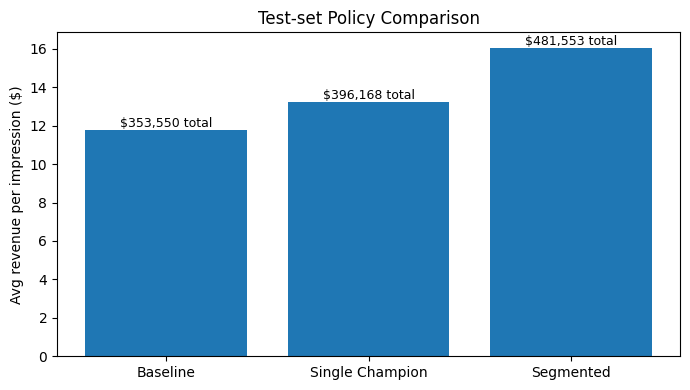

In [ ]:
# Bar chart: test-set performance of three policies
# (1) Baseline (current mix), (2) Champion (one-for-all), (3) Segmented (per-cluster)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- revenue on TEST ---
test_rev = pd.to_numeric(test_df["revenue"], errors="coerce").fillna(0.0)
baseline_avg = float(test_rev.mean())
N = len(test_df)

# --- champion (no segmentation) average $/imp learned on TRAIN ---
if "champ_rev_mean_train" not in globals():
    # fallback: compute champion from train_df
    t = train_df.copy()
    t["revenue"] = pd.to_numeric(t["revenue"], errors="coerce").fillna(0.0)
    champ_rev_mean_train = (t.groupby(["ctaCopy","ctaPlacement"])["revenue"]
                              .mean().sort_values(ascending=False).iloc[0])
champ_avg = float(champ_rev_mean_train)

# --- segmented policy average $/imp on TEST using TRAIN policy table ---
if "policy_tbl_train" not in globals():
    raise ValueError("policy_tbl_train not found. Run the train policy cell first.")

# ensure we have cluster labels for TEST (from train-fitted preprocessor + KMeans)
if "cluster" in test_df.columns:
    cl = test_df["cluster"].to_numpy()
elif "pre_clust_train" in globals() and "kmeans_train" in globals():
    X_test = pre_clust_train.transform(test_df[feature_cols])
    cl = kmeans_train.predict(X_test)
else:
    raise ValueError("Test clusters missing. Fit pre_clust_train & kmeans_train or add test_df['cluster'].")

rev_map = policy_tbl_train.set_index("cluster")["rev_mean"].to_dict()
seg_avg = float(np.mean([rev_map.get(int(c), 0.0) for c in cl]))

# --- totals (optional, for annotations) ---
totals = {
    "Baseline": baseline_avg * N,
    "Single Champion": champ_avg * N,
    "Segmented": seg_avg * N,
}

# --- plot (averages); annotate with totals ---
labels = ["Baseline", "Single Champion", "Segmented"]
values = [baseline_avg, champ_avg, seg_avg]

fig, ax = plt.subplots(figsize=(7,4))
bars = ax.bar(labels, values)
ax.set_ylabel("Avg revenue per impression ($)")
ax.set_title("Test-set Policy Comparison")

for bar, lab in zip(bars, labels):
    y = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, y, f"${totals[lab]:,.0f} total",
            ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


## Thank you
for taking the time to read my notebook.  I really enjoyed the assignment.  I appreciate the opportunity and look forward to hearing from you.

Best regards,
Greg

In [ ]:
print("Thanks! \\(^o^)/")

Thanks! \(^o^)/
